#### Grey Wolf Optimization

The first step to define an optimizer is to define the domain on which the solution is searched. 

Second step is to define what we call error from optimum value or the loss function or the fitness function based on which solutions are judged. 

Third step is to generate random solutions from the domain and judge them based on loss function. 

Next, we update these solutions or solution based on an update expression which is expected to minimize the loss function further. 

In the present code, the loss function/error defined will be mostly based on the previous code for TDOA. We'll just have to make the form amenable to the algorithm we want to run. 


For the present solution we would generate some synthetic time of arrivals beforehand and then using that data we'll process it further. The identified domain is a rectangular domain of size 1km * 1km.


In [1]:
# importing required libraries 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#seeding the random numbers for reproducibilty
np.random.seed(0)
# defining a suitable fitness function
n_rec = 51 # number of receivers
def fitness_GWO(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    ToA_pos = np.zeros_like(ToA)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0],np.shape(pos_matrix)[1]-1))  # vector denoting the position of receivers wrt source
    pos_diff = pos_matrix[1:] - pos_matrix[0]
    ToA_pos[:] = (np.sqrt(pos_diff[:,0]**2 + pos_diff[:,1]**2)).reshape(n_rec,1)/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    
    return error

In [3]:
# Now generating the synthetic data for testing
wave_vel = 1 # m/s
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_wolves = 15 # number of wolves 
initial_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_wolves,n_rec+1,2))  # in order to make sure that the spread is in entire domain

rec_pos_actual =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec,2,10))  # actual position for 50 receivers, 10 configurations
src_pos_actual = np.array([0,0])

In [4]:
n_iter =200000
source_pos_store = np.zeros(shape=(20,2,10)) # storing values in 
error_iter = np.zeros(shape=(n_iter,10))  # creating an array for storing the minimum error for each iteration
for g in range(10): 
    t_rec_ideal = np.zeros(shape =(n_rec,1))
    # calculating the ideal time of arrival
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1,g]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0,g]-src_pos_actual[0])**2).reshape(n_rec,1)
    #introducing noise to account for error in onset detection and sensor
    noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
    t_Rec_real = np.array(t_rec_ideal + noise_t)
    # After this initial assigning of hierarchy, let's create the update expression
    # Note: The first assigned hierarchy is just to ensure that the variables are not blank. This might be removed in revision
    # calculating the min and max time of arrival
    TOA_min = np.min(t_Rec_real)
    TOA_max = np.max(t_Rec_real)
    TOA_avg = np.mean(t_Rec_real)
    wolves_pos = np.copy(initial_pos)

    alpha_pos =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
    alpha_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
    beta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
    beta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
    delta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
    delta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)

    # Source will lie within the annulus with inner radii TOA_min*wave_vel and outer radii TOA_max*wave_vel
    # centered at the mean point of receivers/position of deployer
    
    a = 2  
    # creating an array for storing source positions at every 10,000 steps
    
    fitness_value = np.zeros(shape= n_wolves) # creating an array for storing fitness value for each wolf
    
    #let's make a copy of wolves position at beginning of each iteration


    for i in range(n_iter):
        for j in range(n_wolves):
            fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)
            wolves_pos_copy = np.copy(wolves_pos)
            if fitness_value[j] <= alpha_fitness:
                delta_fitness = beta_fitness
                delta_pos = np.copy(beta_pos)
                beta_fitness = alpha_fitness
                beta_pos = np.copy(alpha_pos)
                alpha_fitness = fitness_value[j]
                alpha_pos = np.copy(wolves_pos[j])
            
            elif fitness_value[j] <= beta_fitness and fitness_value[j] >= alpha_fitness:
                delta_fitness = beta_fitness
                delta_pos = np.copy(beta_pos)
                beta_fitness = fitness_value[j]
                beta_pos = np.copy(wolves_pos[j])
            
            elif fitness_value[j] <= delta_fitness and fitness_value[j] >= beta_fitness:
                delta_fitness = fitness_value[j]
                delta_pos = np.copy(wolves_pos[j])
    
    #Now that hierarchy is assigned let's update the positions
    
        a= a - 2/n_iter
    
        for j in range(n_wolves):
            r1 = np.random.random(size=(np.shape(alpha_pos)))
            r2 = np.random.random(size=(np.shape(alpha_pos)))
            A1 = 2*a*r1 - a
            C1 =2*r2
    
            D_alpha = abs(C1 * alpha_pos - wolves_pos[j])  # distance from the alpha wolf
            X1 = alpha_pos - A1 * D_alpha

            r1 = np.random.random(size=(np.shape(alpha_pos)))
            r2 = np.random.random(size=(np.shape(alpha_pos)))
            A2 = 2*a*r1 - a
            C2 =2*r2
    
            D_beta =abs(C2 * beta_pos - wolves_pos[j])
        
            X2 = beta_pos - A2 * D_beta
    
            r1 = np.random.random(size=(np.shape(alpha_pos)))
            r2 = np.random.random(size=(np.shape(alpha_pos)))
            A3 = 2*a*r1 - a
            C3 =2*r2
            D_delta = abs(C3 * delta_pos- wolves_pos[j])
            X3 = delta_pos - A3*D_delta
        
            wolves_pos[j] = (X1+X2+X3)/3
        
            # restricting the source position by a circle with centre at (300,300)
            if np.sqrt((wolves_pos[j,0,0]-300)**2 + (wolves_pos[j,0,1]-300)**2) > TOA_min*wave_vel or np.sqrt((wolves_pos[j,0,0]-300)**2 + (wolves_pos[j,0,1]-300)**2) < TOA_max*wave_vel:
                wolves_pos[j,0,:] = wolves_pos[j,0,:]
            else:
                wolves_pos[j,0,:] = np.array([300-TOA_avg*wave_vel,300-TOA_avg*wave_vel])[:]   # assign the position on avg line if outside
            # restricting the movement of receivers to a radius of 200 m 
            for k in range(n_rec):
                if np.sqrt((wolves_pos[j,1+k,0]-300)**2 + (wolves_pos[j,1+k,1]-300)**2) > 100:
                    wolves_pos[j,1+k,:] = wolves_pos_copy[j,1+k,:]  
        if(i%10000 == 0):
            source_pos_store[int(i/10000),:,g] = alpha_pos[0,:]
    
        error_iter[i,g] = alpha_fitness

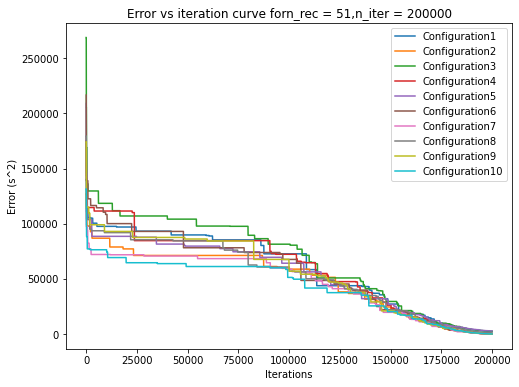

In [6]:
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(np.arange(start= 0,stop = n_iter,step =1), error_iter[:,i],label = 'Configuration'+str(i+1))
plt.title('Error vs iteration curve for'+'n_rec = '+str(n_rec)+',n_iter = '+ str(n_iter))
plt.xlabel('Iterations')
plt.ylabel('Error (s^2)')
plt.legend()

In [8]:
# Printing the value of error at the end of iterations
for i in range(10):
    print('Error for configuration ',i+1,'=',error_iter[-1,i])


Error for configuration  1 = 2278.0658803707643
Error for configuration  2 = 0.008177336653960065
Error for configuration  3 = 2508.259625746072
Error for configuration  4 = 73.09561807678027
Error for configuration  5 = 2780.2409327468044
Error for configuration  6 = 0.009913893680722095
Error for configuration  7 = 0.010980740998903045
Error for configuration  8 = 1072.810181962878
Error for configuration  9 = 39.84032742987373
Error for configuration  10 = 10.640956093017895


Text(0.5, 1.0, 'Movement of source after 10000 iterations for configuration')

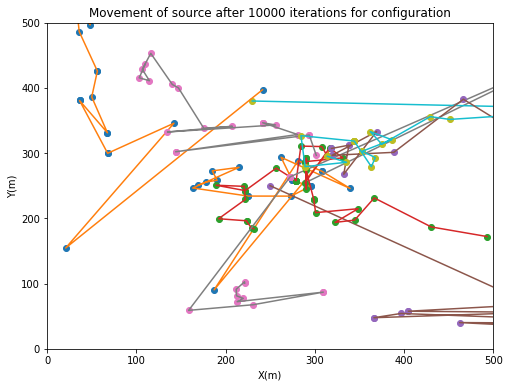

In [11]:
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(source_pos_store[:,0,i],source_pos_store[:,1,i],'o')
    plt.plot(source_pos_store[:,0,i],source_pos_store[:,1,i])
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.xlim(0,500)
plt.ylim(0,500)
plt.title('Movement of source after 10000 iterations for configuration')